Now it's time to build a scoring model :

- We will try 4 differents models : LightGBM (most used on kaggle) / Random Forest / SVM and Logistic Regression

- We will use mlflow to track experiments 

- We will use Pytest or Unittest to do some test while building 

Summary of what have been done in feature engineering : 

- Binary and One Hot encoding for categorical features
- Age in years + binning
- External source weightned and combined
- some basic rates
- some differences

Note : Author is using previous results (from other kernel with more features) in his LightGBM model to improve score. 

#Librairies

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Username: dylan-laurens14@hotmail.fr
Password: 
Repeat for confirmation: 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Username: dylan-laurens14@hotmail.fr
Password: 
Repeat for confirmation: 


In [ ]:
### Mandatory
import pandas as pd
import numpy as np
import datetime as dt
import time
import re
import pickle
import gc

### Plotting
import missingno as mn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Collab and options
from google.colab import drive
import sys
drive.mount('/content/gdrive')
pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

### sklearn 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.feature_selection import SelectFromModel

### LightGBM
from lightgbm import LGBMClassifier

### imblearn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

### MLFlow
import mlflow
import mlflow.sklearn

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/dylan-laurens14@hotmail.fr/Scoring_model")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2136302561654236', creation_time=1677084867432, experiment_id='2136302561654236', last_update_time=1679763505410, lifecycle_stage='active', name='/Users/dylan-laurens14@hotmail.fr/Scoring_model', tags={'mlflow.experiment.sourceName': '/Users/dylan-laurens14@hotmail.fr/Scoring_model',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'dylan-laurens14@hotmail.fr',
 'mlflow.ownerId': '3905542265292646'}>

In [ ]:
seed = 42

# Data

## Old

In [ ]:
def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/cleaned_merged_df.csv")
print(f'This merged dataset has {df.shape[0]} rows and {df.shape[1]} columns. Do not forget that in this merged dataset we have train and test values')
df = reduce_mem_usage(df)

This merged dataset has 356250 rows and 805 columns. Do not forget that in this merged dataset we have train and test values


In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df.isna().sum()

ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN        138151
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN        126314
ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN    123380
APP_EXT_SOURCE_3_DAYS_EMPLOYED          121659
ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX     120207
                                         ...  
ORGANIZATION_TYPE_Industry_type_1            0
ORGANIZATION_TYPE_Housing                    0
ORGANIZATION_TYPE_Hotel                      0
ORGANIZATION_TYPE_Government                 0
SK_ID_CURR                                   0
Length: 804, dtype: int64

In [ ]:
df.isin([np.inf, -np.inf]).sum()

ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN           0
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN           0
ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN    1136
APP_EXT_SOURCE_3_DAYS_EMPLOYED             0
ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX     2116
                                        ... 
ORGANIZATION_TYPE_Industry_type_1          0
ORGANIZATION_TYPE_Housing                  0
ORGANIZATION_TYPE_Hotel                    0
ORGANIZATION_TYPE_Government               0
SK_ID_CURR                                 0
Length: 804, dtype: int64

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
del df 

In [ ]:
gc.collect()

148

In [ ]:
train_df.drop(columns='SK_ID_CURR', inplace=True)

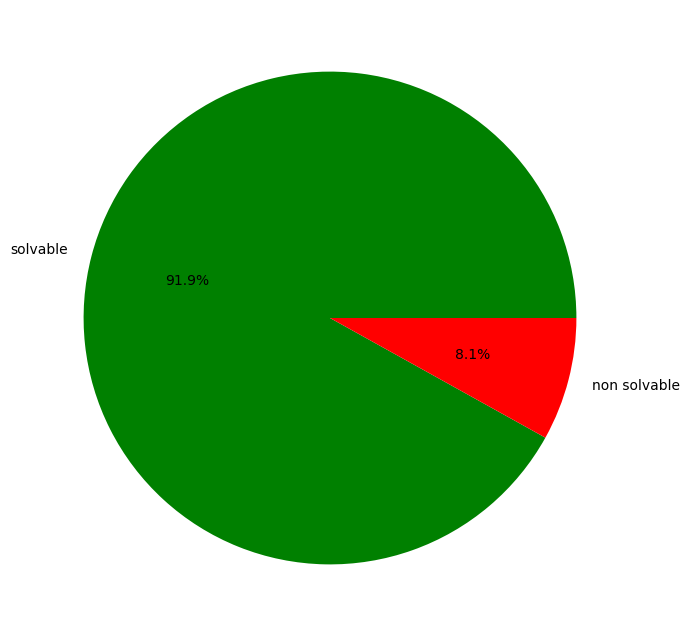

In [ ]:
nb_1 = train_df['TARGET'][train_df['TARGET'] == 1].shape[0]
nb_0 = train_df['TARGET'][train_df['TARGET'] == 0].shape[0]
plt.figure(figsize = (8, 8))
plt.pie([nb_0,nb_1],labels=['solvable','non solvable'],autopct='%.1f%%',colors='gr')
plt.show()

In [ ]:
X_full = train_df.drop(columns= 'TARGET')
y_full = train_df['TARGET']
del test_df
gc.collect()

2407

Data sampling to reduce memory usage and computational time while modeling (1/10)

In [ ]:
# df_sample = train_df.sample(frac=(1/10),
#                             random_state=seed)

In [ ]:
# df_sample.TARGET.value_counts(normalize = True).round(3).unique()

array([0.918, 0.082])

In [ ]:
# X_sample = df_sample.drop('TARGET',axis=1)
# y_sample = df_sample['TARGET']

In [ ]:
# X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample,
#                                                                                 y_sample,
#                                                                                 train_size=0.8, 
#                                                                                 random_state = seed)

In [ ]:
# data_test_sample = X_test_sample.join(y_test_sample)
# data_train_sample = X_train_sample.join(y_train_sample)

# exp_1 = '/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/data_test_sample.pickle'
# exp_2 = '/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/data_train_sample.pickle'

# outfile_1 = open(exp_1,
#                'wb')
# pickle.dump(data_test_sample,
#             outfile_1)
# outfile_1.close()

# outfile_2 = open(exp_2,
#                'wb')
# pickle.dump(data_train_sample,
#             outfile_2)
# outfile_2.close()

## Train model

In [ ]:
file_train = open("/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/data_train_sample.pickle",'rb')
df_train = pickle.load(file_train)
file_train.close()

file_test = open("/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/data_test_sample.pickle",'rb')
df_test = pickle.load(file_test)
file_test.close()

X_train_sample = df_train.drop('TARGET',axis=1)
y_train_sample = df_train['TARGET']
X_test_sample = df_test.drop('TARGET',axis=1)
y_test_sample = df_test['TARGET']

Impute Nan with a simple imputer (Strategy = median)

In [ ]:
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')

In [ ]:
imp_med = imp_med.fit(X_train_sample)
X_train_sample = imp_med.transform(X_train_sample)
X_test_sample = imp_med.transform(X_test_sample)

# Models 

## Random Forest 

Random forests is a supervised learning algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)

## LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
Lower memory usage.
Better accuracy.
Capable of handling large-scale data.

At present, decision tree based machine learning algorithms dominate Kaggle competitions. The winning solutions in these competitions have adopted an alogorithm called XGBoost.

A couple of years ago, Microsoft announced its gradient boosting framework LightGBM. Nowadays, it steals the spotlight in gradient boosting machines. Kagglers start to use LightGBM more than XGBoost. LightGBM is 6 times faster than XGBoost.

## Logistic Regression 

Logistic regression models the probabilities for classification problems with two possible outcomes. It’s an extension of the linear regression model for classification problems.

# Metrics

## AUC : 

AUC measures the entire two-dimensional area underneath the entire ROC curve.

ROC curve (receiver operating characteristic curve) is a plot with True Positive Rate or Recall as X axis and False Positive Rate as Y axis.

## Accuracy :  

The accuracy is defined as the ratio of correctly classified examples among all examples.

## F-Score : 

The F-score is a measure of a model’s accuracy on a dataset. It is used to evaluate binary classification systems.
The F-score is a way of combining the precision (true positive among positive preds) and recall (positive preds vs true positive) of the model, and it is defined as the harmonic mean of the model’s precision and recall.

## F-bêta score :

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0

# Imbalanced Classification

## imbalanced-learn

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. 

In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

# Model Exploratory

In [ ]:
def eval_metrics(actual,pred):
    f1 = f1_score(actual,pred)
    roc_auc = roc_auc_score(actual,pred)
    acc_score = accuracy_score(actual,pred)
    fbeta =fbeta_score(actual,pred, beta=3)
    dictionnary = {}
    dictionnary['f1'] = f1
    dictionnary['roc_auc'] = roc_auc
    dictionnary['accuracy_score'] = acc_score
    dictionnary['fbeta_score'] = fbeta
    return dictionnary

In [ ]:
def running_mlflow_raw(name_run, classif, X, Y):
  current_run = mlflow.start_run(run_name = name_run)
  mlflow.log_param("seed", seed)
  clf = classif
  clf.fit(X, Y)
  y_pred = clf.predict(X_test_sample)
  eval_metrics(y_test_sample,y_pred)
            
  for name,score in zip(eval_metrics(y_test_sample,y_pred).keys(),eval_metrics(y_test_sample,y_pred).values()):
    mlflow.log_metric(name,score)
  
  mlflow.end_run()

In [ ]:
def running_mlflow_scl(name_run, classif, X, Y):
  current_run = mlflow.start_run(run_name = name_run)
  mlflow.log_param("seed", seed)
  scaler = StandardScaler()
  X_train_sample_scl = StandardScaler().fit_transform(X)
  X_test_sample_scl = StandardScaler().fit_transform(X_test_sample)
  clf = classif
  clf.fit(X_train_sample_scl, Y)
  y_pred = clf.predict(X_test_sample_scl)
  eval_metrics(y_test_sample,y_pred)
            
  for name,score in zip(eval_metrics(y_test_sample,y_pred).keys(),eval_metrics(y_test_sample,y_pred).values()):
    mlflow.log_metric(name,score)
  
  mlflow.end_run()

In [ ]:
def fn_fp_scorer(y_true, y_pred):
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10 
    tp_weight = 0
    conf_mat = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_mat.ravel()
    total = tn+fp+fn+tp
    
    return (tn*tn_weight + fp*fp_weight + fn*fn_weight + tp * tp_weight)/total

model_score = make_scorer(fn_fp_scorer, greater_is_better=True)

In [ ]:
def running_mlflow_Hyper(name_run, classif, X,Y, grid):
  current_run = mlflow.start_run(run_name = name_run)
  mlflow.log_param("seed", seed)
  clf = classif
  gcv = GridSearchCV(estimator=clf,
                       param_grid=grid,
                       n_jobs=-1,
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
                       verbose=0,
                       scoring=model_score,
                       refit=True)
  gcv.fit(X, Y)
  print("Best params : \n",
              gcv.best_params_)
  y_pred = gcv.predict(X_test_sample)
  print('scoring :')
  for k,v in zip(eval_metrics(y_test_sample,
                                    y_pred).keys(),
                       eval_metrics(y_test_sample,
                                    y_pred).values()):
    print('{} : {:.3f}'.format(k,v))
    print("model custom metric score: %.3f" % fn_fp_scorer(y_test_sample,
                                                           y_pred))
            
  for name,score in zip(eval_metrics(y_test_sample,y_pred).keys(),eval_metrics(y_test_sample,y_pred).values()):
    mlflow.log_metric(name,score)
  for k,v in zip(gcv.best_params_.keys(),
                           gcv.best_params_.values()):
    mlflow.log_param(k,v)
  mlflow.end_run()

In [ ]:
def running_mlflow_Hyper_feat(name_run, classif, X,Y, grid):
  current_run = mlflow.start_run(run_name = name_run)
  mlflow.log_param("seed", seed)
  clf = classif
  gcv = GridSearchCV(estimator=clf,
                       param_grid=grid,
                       n_jobs=-1,
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
                       verbose=0,
                       scoring=model_score,
                       refit=True)
  gcv.fit(X, Y)
  print("Best params : \n",
              gcv.best_params_)
  y_pred = gcv.predict(X_test_sample_feat)
  print('scoring :')
  for k,v in zip(eval_metrics(y_test_sample,
                                    y_pred).keys(),
                       eval_metrics(y_test_sample,
                                    y_pred).values()):
    print('{} : {:.3f}'.format(k,v))
    print("model custom metric score: %.3f" % fn_fp_scorer(y_test_sample,
                                                           y_pred))
            
  for name,score in zip(eval_metrics(y_test_sample,y_pred).keys(),eval_metrics(y_test_sample,y_pred).values()):
    mlflow.log_metric(name,score)
  for k,v in zip(gcv.best_params_.keys(),
                           gcv.best_params_.values()):
    mlflow.log_param(k,v)
  mlflow.end_run()

In [ ]:
smote = SMOTE(random_state=seed,
              sampling_strategy='minority')
rus = RandomUnderSampler()
ros = RandomOverSampler()

In [ ]:
# X_train_rus, y_train_rus = rus.fit_resample(X_train_sample, y_train_sample)
# X_train_ros, y_train_ros = ros.fit_resample(X_train_sample, y_train_sample)
# X_train_sm, y_train_sm = smote.fit_resample(X_train_sample, y_train_sample)

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, train_size=0.8, random_state = seed)

In [ ]:
X_train_full_rus, y_train_full_rus = rus.fit_resample(X_train_full, y_train_full)

In [ ]:
# param_grid_lgbm = [{'learning_rate' : np.power(10., np.arange(-5, 0)),
#                     'n_estimators' : [10,100,500,1000]}]
# param_grid_rf = [{'n_estimators' : [10,500,1000],
#                   'max_features' : ['sqrt', 'log2'],
#                   'min_samples_split': [5,10],
#                   'max_depth' : [3,10,15]}]
# param_grid_lr = [{'penalty' : ['l1', 'l2', 'elasticnet', None], 
# 'C' : [100, 10, 1.0, 0.1, 0.01], 
# 'solver' : ['saga']}]

In [ ]:
# ###Logistic Regression
# running_mlflow_raw('LR_raw_smote', LogisticRegression(), X_train_sm, y_train_sm)
# running_mlflow_scl('LR_scl_smote', LogisticRegression(), X_train_sm, y_train_sm)

# running_mlflow_raw('LR_raw_rus', LogisticRegression(), X_train_rus, y_train_rus)
# running_mlflow_scl('LR_scl_rus', LogisticRegression(), X_train_rus, y_train_rus)

# running_mlflow_raw('LR_raw_ros', LogisticRegression(), X_train_ros, y_train_ros)
# running_mlflow_scl('LR_scl_ros', LogisticRegression(), X_train_ros, y_train_ros)

# ### Decision tree
# running_mlflow_raw('DT_raw_smote', DecisionTreeClassifier(), X_train_sm, y_train_sm)
# running_mlflow_scl('DT_scl_smote', DecisionTreeClassifier(), X_train_sm, y_train_sm)

# running_mlflow_raw('DT_raw_rus', DecisionTreeClassifier(), X_train_rus, y_train_rus)
# running_mlflow_scl('DT_scl_rus', DecisionTreeClassifier(), X_train_rus, y_train_rus)

# running_mlflow_raw('DT_raw_ros', DecisionTreeClassifier(), X_train_ros, y_train_ros)
# running_mlflow_scl('DT_scl_ros', DecisionTreeClassifier(), X_train_ros, y_train_ros)

# ### Random Forest
# running_mlflow_raw('RF_raw_smote', RandomForestClassifier(), X_train_sm, y_train_sm)
# running_mlflow_scl('RF_scl_smote', RandomForestClassifier(), X_train_sm, y_train_sm)

# running_mlflow_raw('RF_raw_rus', RandomForestClassifier(), X_train_rus, y_train_rus)
# running_mlflow_scl('RF_scl_rus', RandomForestClassifier(), X_train_rus, y_train_rus)

# running_mlflow_raw('RF_raw_ros', RandomForestClassifier(), X_train_ros, y_train_ros)
# running_mlflow_scl('RF_scl_ros', RandomForestClassifier(), X_train_ros, y_train_ros)

# ### LGBM
# running_mlflow_raw('LGBM_raw_smote', LGBMClassifier(), X_train_sm, y_train_sm)
# running_mlflow_scl('LGBM_scl_smote', LGBMClassifier(), X_train_sm, y_train_sm)

# running_mlflow_raw('LGBM_raw_rus', LGBMClassifier(), X_train_rus, y_train_rus)
# running_mlflow_scl('LGBM_scl_rus', LGBMClassifier(), X_train_rus, y_train_rus)

# running_mlflow_raw('LGBM_raw_ros', LGBMClassifier(), X_train_ros, y_train_ros)
# running_mlflow_scl('LGBM_scl_ros', LGBMClassifier(), X_train_ros, y_train_ros)

In [ ]:
# running_mlflow_Hyper('LR_Hyper_raw_smote', LogisticRegression(), X_train_sm, y_train_sm, param_grid_lr)
# running_mlflow_Hyper('RF_Hyper_raw_rus', RandomForestClassifier(), X_train_rus, y_train_rus, param_grid_rf)
# running_mlflow_Hyper('LGBM_Hyper_raw_rus', LGBMClassifier(), X_train_rus, y_train_rus, param_grid_lgbm)

Best params : 
 {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 1000}
scoring :
f1 : 0.263
model custom metric score: 0.365
roc_auc : 0.683
model custom metric score: 0.365
accuracy_score : 0.683
model custom metric score: 0.365
fbeta_score : 0.518
model custom metric score: 0.365
Best params : 
 {'learning_rate': 0.1, 'n_estimators': 1000}
scoring :
f1 : 0.263
model custom metric score: 0.359
roc_auc : 0.679
model custom metric score: 0.359
accuracy_score : 0.692
model custom metric score: 0.359
fbeta_score : 0.509
model custom metric score: 0.359


# Feature Selection on LGBM

In [ ]:
# lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
#             reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

# embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
# embeded_lgb_selector.fit(X_train_full_rus, y_train_full_rus)
# embeded_lgb_support = embeded_lgb_selector.get_support()
# embeded_lgb_feature = df_train.drop(columns = ['TARGET']).loc[:,embeded_lgb_support].columns.tolist()

In [ ]:
# len(embeded_lgb_feature)

371

In [ ]:
# embeded_lgb_feature

['ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'APP_EXT_SOURCE_3_DAYS_EMPLOYED',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MIN',
 'ACTIVE_DEBT_CREDIT_DIFF_MIN',
 'ACTIVE_DEBT_CREDIT_DIFF_MAX',
 'ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MEAN',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MAX',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'APPROVED_APP_CREDIT_PERC_VAR',
 'PREV_SIMPLE_INTERESTS_MEAN',
 'INS_D365AMT_PAYMENT_MAX',
 'INS_D365AMT_PAYMENT_SUM',
 'INS_D365PAYMENT_DIFF_MEAN',
 'INS_D365PAYMENT_DIFF_MAX',
 'INS_D365PAYMENT_DIFF_SUM',
 'INS_D365PAYMENT_PERC_MEAN',
 'INS_D365DPD_DIFF_MEAN',
 'INS_D365DPD_DIFF_MAX',
 'INS_D365DPD_MEAN',
 'INS_D365DPD_SUM',
 'INS_D365INS_IS_DPD_UNDER_120_MEAN',
 'INS_D365INS_IS_DPD_UNDER_120_SUM',
 

In [ ]:
embeded_lgb_feature = ['ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'APP_EXT_SOURCE_3_DAYS_EMPLOYED',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX',
 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MIN',
 'ACTIVE_DEBT_CREDIT_DIFF_MIN',
 'ACTIVE_DEBT_CREDIT_DIFF_MAX',
 'ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MEAN',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MAX',
 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'APPROVED_APP_CREDIT_PERC_VAR',
 'PREV_SIMPLE_INTERESTS_MEAN',
 'INS_D365AMT_PAYMENT_MAX',
 'INS_D365AMT_PAYMENT_SUM',
 'INS_D365PAYMENT_DIFF_MEAN',
 'INS_D365PAYMENT_DIFF_MAX',
 'INS_D365PAYMENT_DIFF_SUM',
 'INS_D365PAYMENT_PERC_MEAN',
 'INS_D365DPD_DIFF_MEAN',
 'INS_D365DPD_DIFF_MAX',
 'INS_D365DPD_MEAN',
 'INS_D365DPD_SUM',
 'INS_D365INS_IS_DPD_UNDER_120_MEAN',
 'INS_D365INS_IS_DPD_UNDER_120_SUM',
 'INS_D365AMT_PAYMENT_MEAN',
 'INS_D365DPD_DIFF_MIN',
 'INS_D365DAYS_INSTALMENT_MAX',
 'INS_D365AMT_INSTALMENT_SUM',
 'INS_D365SK_ID_CURR_COUNT',
 'INS_D365AMT_INSTALMENT_MEAN',
 'INS_D365DAYS_INSTALMENT_SUM',
 'INS_D365AMT_INSTALMENT_MAX',
 'INS_D365DAYS_INSTALMENT_MEAN',
 'INS_D365DAYS_ENTRY_PAYMENT_SUM',
 'INS_D365DAYS_ENTRY_PAYMENT_MAX',
 'INS_D365DAYS_ENTRY_PAYMENT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_SK_ID_BUREAU_COUNT',
 'ACTIVE_MONTHS_BALANCE_SIZE_SUM',
 'ACTIVE_AMT_ANNUITY_SUM',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'CLOSED_DEBT_CREDIT_DIFF_MEAN',
 'CLOSED_DEBT_CREDIT_DIFF_MAX',
 'CLOSED_DEBT_CREDIT_DIFF_MIN',
 'APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio',
 'BURO_DAYS_CREDIT_VAR',
 'CLOSED_ENDDATE_DIF_MEAN',
 'CLOSED_ENDDATE_DIF_MAX',
 'CLOSED_ENDDATE_DIF_MIN',
 'CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
 'CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MAX',
 'CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MIN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_ENDDATE_DIF_MEAN',
 'BURO_ENDDATE_DIF_MIN',
 'BURO_ENDDATE_DIF_MAX',
 'PREV_APP_CREDIT_PERC_VAR',
 'CLOSED_BUREAU_CREDIT_FACT_DIFF_MIN',
 'CLOSED_BUREAU_CREDIT_FACT_DIFF_MAX',
 'CLOSED_DAYS_ENDDATE_FACT_MAX',
 'CLOSED_DAYS_ENDDATE_FACT_MIN',
 'CLOSED_BUREAU_CREDIT_FACT_DIFF_MEAN',
 'CLOSED_DAYS_ENDDATE_FACT_MEAN',
 'CLOSED_MONTHS_BALANCE_SIZE_SUM',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'CLOSED_AMT_CREDIT_SUM_MAX',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
 'CLOSED_DAYS_CREDIT_MEAN',
 'CLOSED_DAYS_CREDIT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'BURO_DAYS_ENDDATE_FACT_MEAN',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MEAN',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MAX',
 'BURO_DAYS_ENDDATE_FACT_MIN',
 'BURO_BUREAU_CREDIT_FACT_DIFF_MIN',
 'BURO_DAYS_ENDDATE_FACT_MAX',
 'APPROVED_SIMPLE_INTERESTS_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'APP_EXT_SOURCE_2_EXT_SOURCE_3',
 'EXT_SOURCE_3',
 'APP_SCORE3_TO_BIRTH_RATIO',
 'APP_EXT_SOURCE_2_DAYS_EMPLOYED',
 'INCOME_TO_EMPLOYED_RATIO',
 'APP_DAYS_EMPLOYED_DAYS_BIRTH_diff',
 'DAYS_EMPLOYED_PERC',
 'APP_INCOME_TO_EMPLOYED_RATIO',
 'APPS_INCOME_EMPLOYED_RATIO',
 'DAYS_EMPLOYED',
 'BURO_BUREAU_CREDIT_DEBT_RATIO_MEAN',
 'BURO_BUREAU_CREDIT_DEBT_RATIO_MAX',
 'BURO_DEBT_CREDIT_DIFF_MAX',
 'BURO_DEBT_CREDIT_DIFF_MIN',
 'BURO_DEBT_CREDIT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MAX',
 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_BUREAU_CREDIT_ENDDATE_DIFF_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_CREDIT_TYPE_Mortgage_MEAN',
 'BURO_CREDIT_TYPE_Credit_card_MEAN',
 'BURO_CREDIT_TYPE_Consumer_credit_MEAN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_SUM',
 'BURO_SK_ID_BUREAU_COUNT',
 'APPROVED_DAYS_TERMINATION_MAX',
 'PREV_DAYS_TERMINATION_MAX',
 'APP_SCORE2_TO_PHONE_CHANGE_RATIO',
 'APPROVED_DAYS_LAST_DUE_DIFF_MEAN',
 'PREV_DAYS_LAST_DUE_DIFF_MEAN',
 'APPROVED_DAYS_LAST_DUE_DIFF_MAX',
 'PREV_DAYS_LAST_DUE_DIFF_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'PHONE_TO_BIRTH_RATIO',
 'APPROVED_RATE_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_DOWN_PAYMENT_TO_CREDIT_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_RATE_DOWN_PAYMENT_MIN',
 'APPROVED_RATE_DOWN_PAYMENT_MAX',
 'PREV_RATE_DOWN_PAYMENT_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'PREV_RATE_DOWN_PAYMENT_MAX',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_AMT_GOODS_PRICE_MAX',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_AMT_GOODS_PRICE_MIN',
 'POS_CNT_INSTALMENT_MAX',
 'POS_CNT_INSTALMENT_FUTURE_MAX',
 'POS_CNT_INSTALMENT_FUTURE_MEAN',
 'POS_CNT_INSTALMENT_MEAN',
 'POS_CNT_INSTALMENT_FUTURE_SUM',
 'POS_MONTHS_BALANCE_MAX',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'POS_COUNT',
 'POS_REMAINING_INSTALMENTS_RATIO',
 'POS_REMAINING_INSTALMENTS',
 'POS_LOAN_COMPLETED_MEAN',
 'POS_SK_DPD_DEF_SUM',
 'POS_MONTHS_BALANCE_SIZE',
 'POS_MONTHS_BALANCE_MIN',
 'POS_SK_DPD_DEF_MEAN',
 'POS_SK_DPD_DEF_MAX',
 'POS_SK_ID_CURR_COUNT',
 'POS_CNT_INSTALMENT_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN',
 'APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX',
 'APPROVED_SIMPLE_INTERESTS_MAX',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'APPROVED_AMT_ANNUITY_MIN',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_DAYS_DECISION_MAX',
 'APPROVED_DAYS_DECISION_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'APPROVED_AMT_CREDIT_MEAN',
 'APPROVED_AMT_CREDIT_MAX',
 'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
 'APPROVED_APPLICATION_CREDIT_DIFF_MIN',
 'APPROVED_APPLICATION_CREDIT_DIFF_MAX',
 'APPROVED_APPLICATION_CREDIT_DIFF_MEAN',
 'APPROVED_APPLICATION_CREDIT_DIFF_SUM',
 'APPROVED_DAYS_DECISION_MIN',
 'APPROVED_AMT_APPLICATION_MAX',
 'APPROVED_AMT_APPLICATION_SUM',
 'APPROVED_AMT_CREDIT_SUM',
 'APPROVED_HOUR_APPR_PROCESS_START_MAX',
 'APPROVED_HOUR_APPR_PROCESS_START_MIN',
 'APPROVED_AMT_GOODS_PRICE_SUM',
 'APPROVED_AMT_CREDIT_MIN',
 'APPROVED_AMT_DOWN_PAYMENT_SUM',
 'APPROVED_AMT_ANNUITY_SUM',
 'APPROVED_AMT_APPLICATION_MIN',
 'APPROVED_AMT_APPLICATION_MEAN',
 'PREV_AMT_GOODS_PRICE_MAX',
 'PREV_AMT_GOODS_PRICE_MEAN',
 'PREV_AMT_GOODS_PRICE_MIN',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX',
 'PREV_SIMPLE_INTERESTS_MAX',
 'PREV_AMT_ANNUITY_MIN',
 'PREV_AMT_ANNUITY_MEAN',
 'PREV_AMT_ANNUITY_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_PAYMENT_PERC_VAR',
 'PREV_APP_CREDIT_PERC_MEAN',
 'PREV_APP_CREDIT_PERC_MIN',
 'PREV_APP_CREDIT_PERC_MAX',
 'INSTAL_PAYMENT_DIFF_VAR',
 'INSTAL_DPD_VAR',
 'INSTAL_DBD_VAR',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'PREV_CODE_REJECT_REASON_HC_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cash_through_the_bank_MEAN',
 'PREV_APPLICATION_CREDIT_DIFF_MAX',
 'PREV_CNT_PAYMENT_SUM',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_DAYS_DECISION_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_AMT_GOODS_PRICE_SUM',
 'PREV_AMT_DOWN_PAYMENT_SUM',
 'PREV_AMT_CREDIT_SUM',
 'PREV_AMT_CREDIT_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'PREV_AMT_CREDIT_MIN',
 'PREV_AMT_APPLICATION_MEAN',
 'PREV_AMT_APPLICATION_MAX',
 'PREV_AMT_APPLICATION_MIN',
 'PREV_AMT_ANNUITY_SUM',
 'PREV_APPLICATION_CREDIT_DIFF_MIN',
 'PREV_APPLICATION_CREDIT_DIFF_MEAN',
 'PREV_APPLICATION_CREDIT_DIFF_SUM',
 'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN',
 'PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN',
 'PREV_AMT_APPLICATION_SUM',
 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_high_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Mobile_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Furniture_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Photo_Cinema_Equipment_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Audio_Video_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN',
 'PREV_NAME_PRODUCT_TYPE_x_sell_MEAN',
 'PREV_CHANNEL_TYPE_Country_wide_MEAN',
 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN',
 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN',
 'PREV_NAME_CLIENT_TYPE_New_MEAN',
 'PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN',
 'PREV_NAME_TYPE_SUITE_nan_MEAN',
 'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN',
 'PREV_PRODUCT_COMBINATION_POS_mobile_with_interest_MEAN',
 'PREV_NAME_YIELD_GROUP_high_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_XNA_MEAN',
 'PREV_NAME_YIELD_GROUP_XNA_MEAN',
 'PREV_NAME_YIELD_GROUP_middle_MEAN',
 'PREV_NAME_YIELD_GROUP_low_normal_MEAN',
 'PREV_NAME_YIELD_GROUP_low_action_MEAN',
 'INSTAL_PAYMENT_PERC_MEAN',
 'INSTAL_PAYMENT_PERC_SUM',
 'INSTAL_LATE_PAYMENT_RATIO_MEAN',
 'INSTAL_AMT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MIN',
 'INSTAL_DBD_diff_MAX',
 'INSTAL_DBD_diff_MIN',
 'INSTAL_AMT_PAYMENT_MAX',
 'INSTAL_PAYMENT_DIFF_MAX',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_DBD_diff_MEAN',
 'INSTAL_DPD_diff_MAX',
 'INSTAL_DPD_diff_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_AMT_PAYMENT_MIN',
 'INSTAL_DPD_diff_MIN',
 'INSTAL_COUNT',
 'INSTAL_PAYMENT_DIFFERENCE_MEAN',
 'INSTAL_DPD_MEAN',
 'INSTAL_DPD_SUM',
 'INSTAL_DBD_MAX',
 'INSTAL_DBD_MEAN',
 'INSTAL_DBD_SUM',
 'INSTAL_PAYMENT_DIFF_SUM',
 'INSTAL_AMT_INSTALMENT_MAX',
 'INSTAL_AMT_INSTALMENT_SUM',
 'INSTAL_AMT_INSTALMENT_MIN',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_SK_ID_PREV_SIZE',
 'INSTAL_AMT_INSTALMENT_MEAN',
 'INSTAL_LATE_PAYMENT_MEAN',
 'INSTAL_LATE_PAYMENT_SUM',
 'INSTAL_SIGNIFICANT_LATE_PAYMENT_MEAN',
 'INSTAL_SIGNIFICANT_LATE_PAYMENT_SUM',
 'INSTAL_DPD_7_MEAN',
 'INSTAL_DAYS_INSTALMENT_MEAN',
 'INSTAL_DAYS_INSTALMENT_MAX',
 'INSTAL_DAYS_INSTALMENT_SUM',
 'INSTAL_INS_IS_DPD_UNDER_120_MEAN',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'APP_SCORE2_TO_POP_RATIO',
 'APP_SCORE2_TO_CITY_RATING_RATIO',
 'APP_SCORE2_TO_REGION_RATING_RATIO',
 'APP_SCORE2_TO_CREDIT_RATIO',
 'APP_SCORE2_TO_BIRTH_RATIO',
 'EXT_SOURCE_2',
 'CREDIT_TO_GOODS_RATIO_2',
 'APPS_GOODS_INCOME_RATIO',
 'CREDIT_TO_GOODS_RATIO',
 'AMT_GOODS_PRICE',
 'EXT_SOURCES_VAR',
 'EXT_SOURCES_MIN',
 'EXT_SOURCES_MEAN',
 'EXT_SOURCES_NANMEDIAN',
 'EXT_SOURCES_MAX',
 'APPS_EXT_SOURCE_MEAN',
 'AMT_ANNUITY',
 'APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'APPS_CNT_FAM_INCOME_RATIO',
 'INCOME_PER_PERSON',
 'NAME_EDUCATION_TYPE_Higher_education',
 'NAME_INCOME_TYPE_Working',
 'OCCUPATION_TYPE_Core_staff',
 'NAME_EDUCATION_TYPE_Secondary_secondary_special',
 'OCCUPATION_TYPE_Accountants',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Drivers',
 'REG_CITY_NOT_LIVE_CITY',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_WORK_PHONE',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'FLAG_OWN_CAR',
 'CODE_GENDER',
 'FLAG_DOCUMENT_3',
 'APPS_EXT_SOURCE_STD',
 'ID_TO_BIRTH_RATIO',
 'INCOME_TO_BIRTH_RATIO',
 'INCOME_CREDIT_PERC',
 'NEW_DOC_KURT',
 'WALLSMATERIAL_MODE_Panel',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Industry_type_9']

In [ ]:
X_full_feat = X_full[embeded_lgb_feature]

In [ ]:
X_train_full_feat, X_test_full_feat, y_train_full_feat, y_test_full_feat = train_test_split(X_full_feat, y_full, train_size=0.8, random_state = seed)
X_train_full_rus, y_train_full_rus = rus.fit_resample(X_train_full_feat, y_train_full_feat)

# Hyperparameter tuning using Optuna librairy

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "seed": seed,
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "n_estimators": trial.suggest_int("n_estimators", 2, 10000),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-4, 10.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 2, 256),
        "reg_alpha" : trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-8, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 10.0, log=True)
    }
    gbm = LGBMClassifier(**param)
    gbm.fit(X_train_full_rus, y_train_full_rus)
    preds = gbm.predict(X_test_full_feat)
    accuracy = roc_auc_score(y_test_full_feat, preds)
    return accuracy

sampler = TPESampler(seed = seed)
study = optuna.create_study(study_name="lightgbm", direction="maximize")
study.optimize(objective, n_trials=30)


print('Best parameters:', study.best_params, 'Best value:', study.best_value)

ModuleNotFoundError: ignored

In [ ]:
# final_params = {'num_leaves': 16, 'n_estimators': 9903, 'learning_rate': 0.009002025568465149, 'max_depth': 74, 'reg_alpha': 9.991242673285447, 'reg_lambda': 0.0369341972808533, 'min_child_samples': 6, 'min_split_gain': 0.3022682956431566, 'min_child_weight': 4.122520312225925}
# current_run = mlflow.start_run(run_name = 'LGBM_hyper_feat_optuna_rus_final')
# mlflow.log_param("seed", seed)
# clf = LGBMClassifier(**final_params)
# clf.fit(X_train_full_rus, y_train_full_rus)
# y_pred = clf.predict(X_test_full_feat)
# eval_metrics(y_test_full_feat,y_pred)
            
# for name,score in zip(eval_metrics(y_test_full_feat,y_pred).keys(),eval_metrics(y_test_full_feat,y_pred).values()):
#   mlflow.log_metric(name,score)
  
# mlflow.end_run()

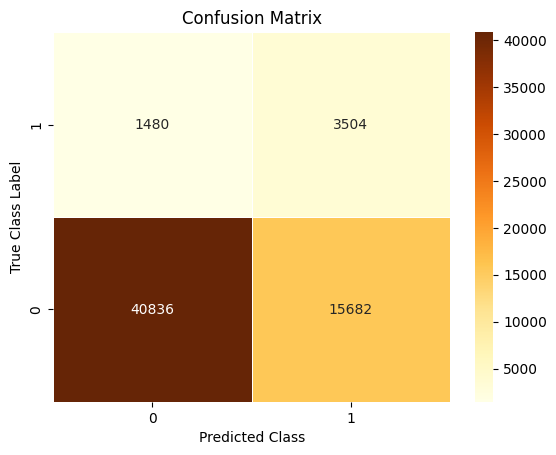

0.7127903171744827


In [ ]:
final_params = {'num_leaves': 16, 'n_estimators': 9903, 'learning_rate': 0.009002025568465149, 'max_depth': 74, 'reg_alpha': 9.991242673285447, 'reg_lambda': 0.0369341972808533, 'min_child_samples': 6, 'min_split_gain': 0.3022682956431566, 'min_child_weight': 4.122520312225925}
clf = LGBMClassifier(**final_params)
clf.fit(X_train_full_rus, y_train_full_rus)
y_pred = clf.predict(X_test_full_feat)
conf_mx = confusion_matrix(y_test_full_feat, y_pred)
sns.heatmap(conf_mx, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.ylim(0, 2)
plt.xlabel("Predicted Class")
plt.ylabel("True Class Label")
plt.show()

print(roc_auc_score(y_test_full_feat, y_pred))

In [ ]:
# lgbc_2=LGBMClassifier(**final_params)

# embeded_lgb_selector_2 = SelectFromModel(lgbc_2, threshold='1.25*median')
# embeded_lgb_selector_2.fit(X_train_full_rus, y_train_full_rus)
# embeded_lgb_support_2 = embeded_lgb_selector_2.get_support()
# embeded_lgb_feature_2 = X_full_feat.loc[:,embeded_lgb_support_2].columns.tolist()
# print(len(embeded_lgb_feature_2))
# print(embeded_lgb_feature_2)

### Not improving the model

129
['APP_EXT_SOURCE_3_DAYS_EMPLOYED', 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX', 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MIN', 'ACTIVE_DEBT_CREDIT_DIFF_MIN', 'ACTIVE_DEBT_CREDIT_DIFF_MAX', 'ACTIVE_DEBT_CREDIT_DIFF_MEAN', 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'APPROVED_APP_CREDIT_PERC_VAR', 'PREV_SIMPLE_INTERESTS_MEAN', 'INS_D365DPD_DIFF_MEAN', 'INS_D365DPD_DIFF_MIN', 'INS_D365DAYS_INSTALMENT_SUM', 'INS_D365DAYS_INSTALMENT_MEAN', 'INS_D365DAYS_ENTRY_PAYMENT_MAX', 'INS_D365DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DEBT_CREDIT_DIFF_MIN', 'APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio', 'CLOSED_ENDDATE_DIF_MIN', 'CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN', 'CLOSED_BUREAU_CREDIT_ENDDATE_DIFF_MAX', 'BURO_ENDDATE_DIF_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'CLOS

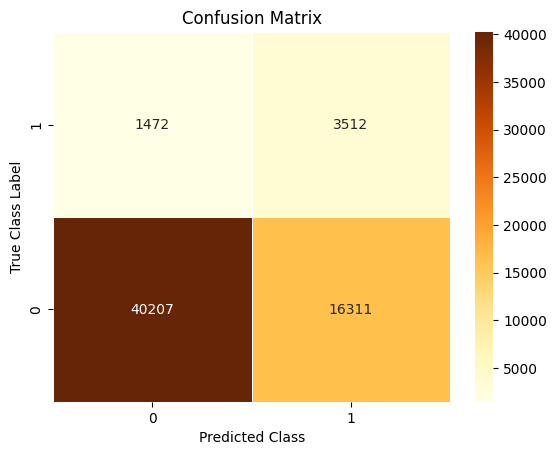

0.7080282865039317


In [ ]:
# X_train_full_rus_feat_2 = X_train_full_rus[embeded_lgb_feature_2]
# X_test_full_feat_2 = X_test_full_feat[embeded_lgb_feature_2]


# final_params = {'num_leaves': 16, 'n_estimators': 9903, 'learning_rate': 0.009002025568465149, 'max_depth': 74, 'reg_alpha': 9.991242673285447, 'reg_lambda': 0.0369341972808533, 'min_child_samples': 6, 'min_split_gain': 0.3022682956431566, 'min_child_weight': 4.122520312225925}
# clf_test = LGBMClassifier(**final_params)
# clf_test.fit(X_train_full_rus_feat_2, y_train_full_rus)
# y_pred = clf_test.predict(X_test_full_feat_2)
# conf_mx = confusion_matrix(y_test_full_feat, y_pred)
# sns.heatmap(conf_mx, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
# plt.title('Confusion Matrix')
# plt.ylim(0, 2)
# plt.xlabel("Predicted Class")
# plt.ylabel("True Class Label")
# plt.show()

# print(roc_auc_score(y_test_full_feat, y_pred)) 

### Not improving the model

#Threshold Optimisation

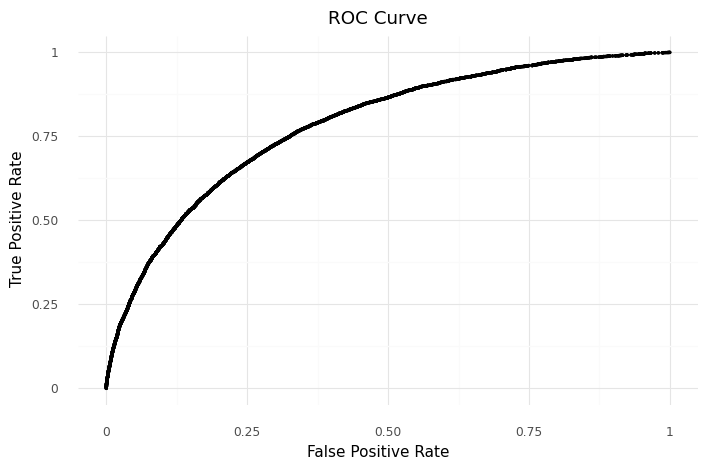

<ggplot: (8782767962323)>

In [ ]:
from numpy import argmax
from sklearn.metrics import roc_curve, precision_recall_curve 
import plotnine
from plotnine import ggplot, geom_point, geom_line, geom_text, labs, xlab, ylab, theme_minimal, aes

### Techniques used in this lesson : https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

y_pred = clf.predict_proba(X_test_full_feat)
y_pred = y_pred[:, 1]

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_full_feat, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.4836 with G-Mean: 0.7134
FPR: 0.2939, TPR: 0.7209


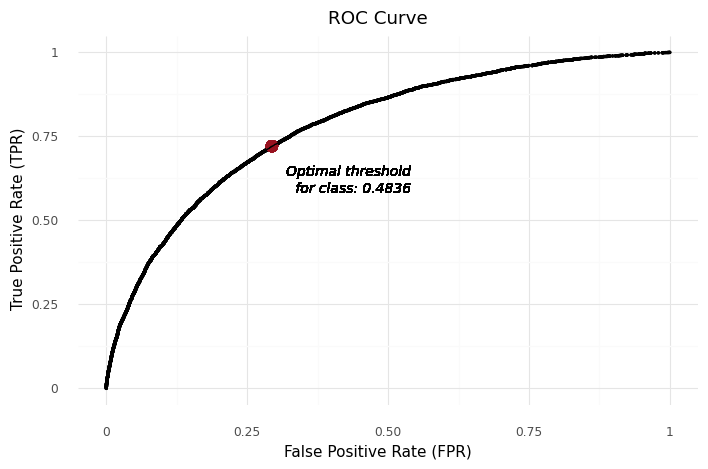

<ggplot: (8782767869817)>

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.4785 with Youden J statistic: 0.7134
FPR: 0.2992, TPR: 0.7263


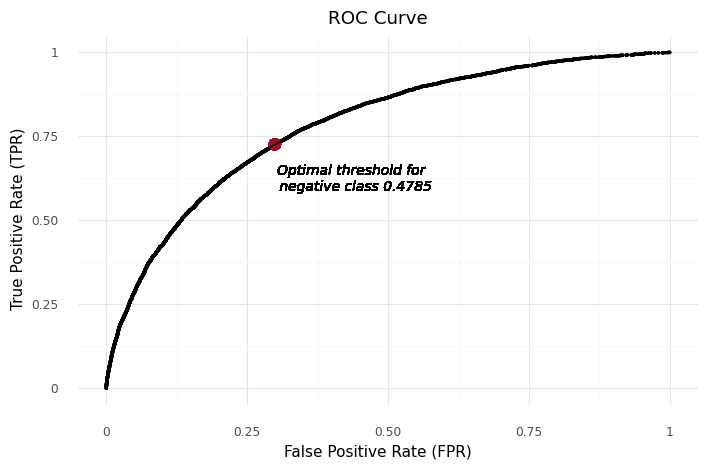

<ggplot: (8782690456631)>

In [ ]:
# Calculate the Youden's J statistic
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

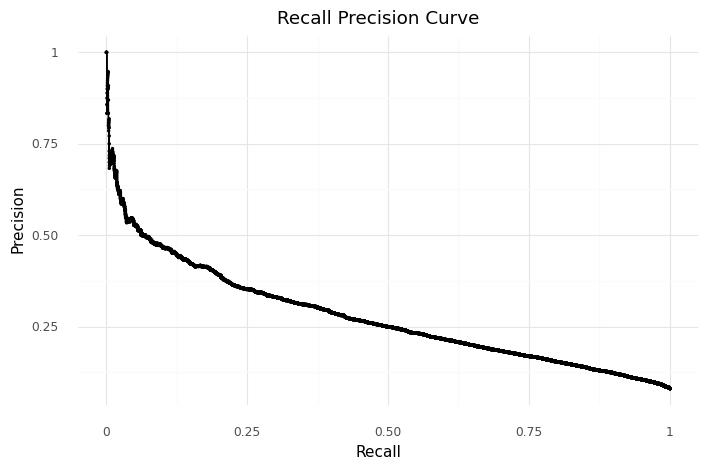

<ggplot: (8782767708100)>

In [ ]:
# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_full_feat, y_pred)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 0.744 with F-Score: 0.337
Recall: 0.393, Precision: 0.296


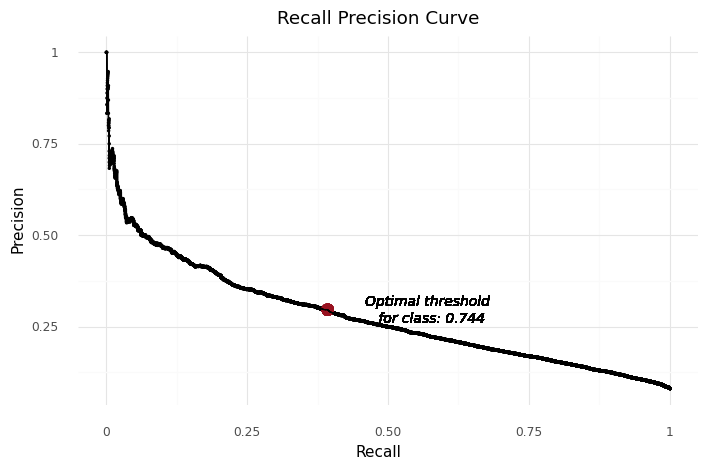

<ggplot: (8782693490429)>

In [ ]:
# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[~np.isnan(fscore)]
# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 3)
fscoreOpt = round(fscore[index], ndigits = 3)
recallOpt = round(recall[index], ndigits = 3)
precisionOpt = round(precision[index], ndigits = 3)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 1000
Best Threshold: 0.53 with F-Score: 0.4241


,F-score,Threshold
0,0.0,0.000
1,0.0,0.001
2,0.0,0.002
3,0.0,0.003
4,0.0,0.004


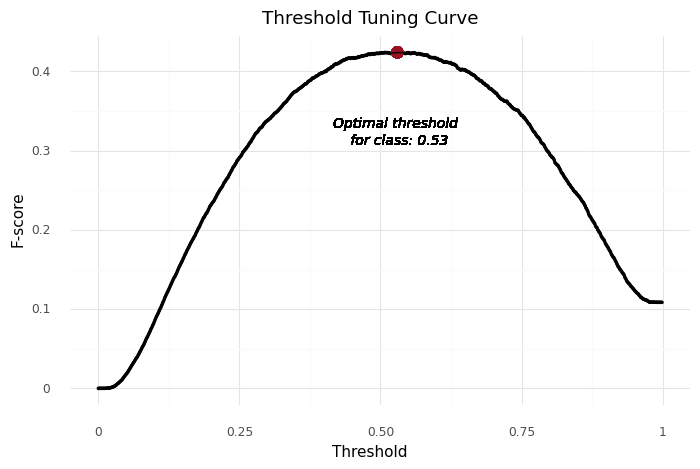

<ggplot: (8782690453273)>

In [ ]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.001)
fscore = np.zeros(shape=(len(thresholds)))
y_pred = clf.predict_proba(X_test_full_feat)
y_pred = y_pred[:, 1]
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = fn_fp_scorer(y_test_full_feat, y_pred_prob) #f1_score(y_test_full_feat, y_pred_prob) 

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
display(df_threshold_tuning.head())

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

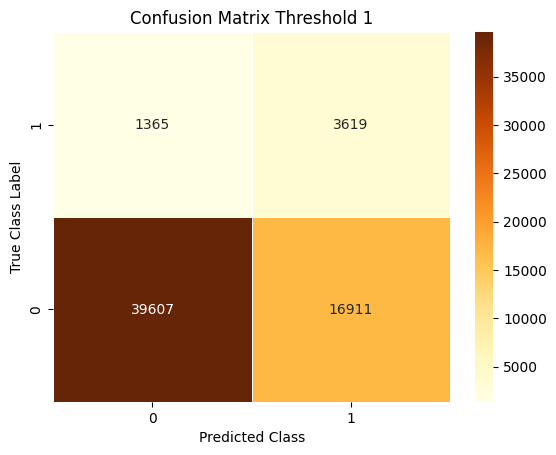

0.7134545929684925


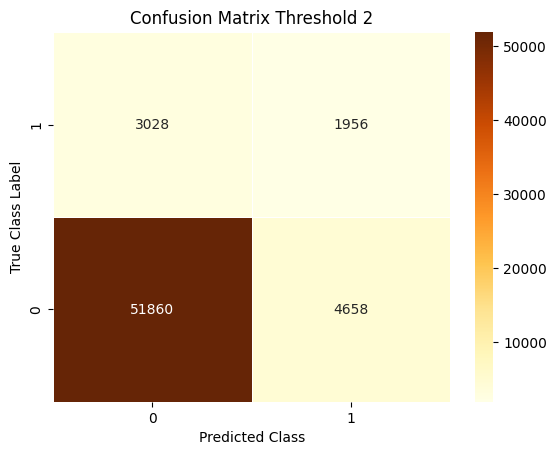

0.6550198186835973


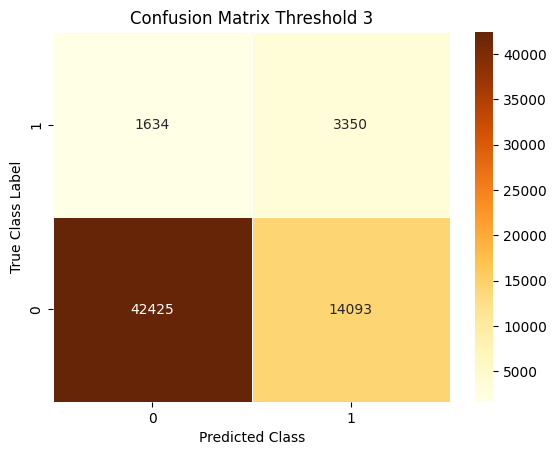

0.7113983473893769


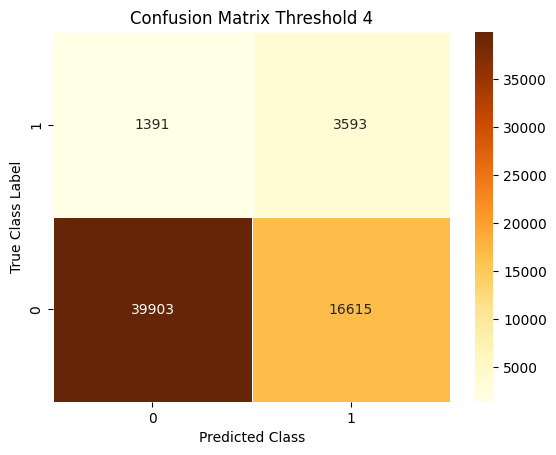

0.7134648810302455


In [ ]:
threshold_1 = 0.4785
threshold_2 = 0.744
threshold_3 = 0.53
threshold_4 = 0.4836
y_pred_thresh_1 = clf.predict_proba(X_test_full_feat)
y_pred_thresh_1 = (y_pred_thresh_1[:,1] >= threshold_1 )*1

y_pred_thresh_2 = clf.predict_proba(X_test_full_feat)
y_pred_thresh_2 = (y_pred_thresh_2[:,1] >= threshold_2 )*1

y_pred_thresh_3 = clf.predict_proba(X_test_full_feat)
y_pred_thresh_3 = (y_pred_thresh_3[:,1] >= threshold_3 )*1

y_pred_thresh_4 = clf.predict_proba(X_test_full_feat)
y_pred_thresh_4 = (y_pred_thresh_4[:,1] >= threshold_4 )*1

conf_mx_1 = confusion_matrix(y_test_full_feat, y_pred_thresh_1)
sns.heatmap(conf_mx_1, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix Threshold 1')
plt.ylim(0, 2)
plt.xlabel("Predicted Class")
plt.ylabel("True Class Label")
plt.show()

print(roc_auc_score(y_test_full_feat, y_pred_thresh_1))

conf_mx_2 = confusion_matrix(y_test_full_feat, y_pred_thresh_2)
sns.heatmap(conf_mx_2, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix Threshold 2')
plt.ylim(0, 2)
plt.xlabel("Predicted Class")
plt.ylabel("True Class Label")
plt.show()

print(roc_auc_score(y_test_full_feat, y_pred_thresh_2))

conf_mx_3 = confusion_matrix(y_test_full_feat, y_pred_thresh_3)
sns.heatmap(conf_mx_3, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix Threshold 3')
plt.ylim(0, 2)
plt.xlabel("Predicted Class")
plt.ylabel("True Class Label")
plt.show()

print(roc_auc_score(y_test_full_feat, y_pred_thresh_3))

conf_mx_4 = confusion_matrix(y_test_full_feat, y_pred_thresh_4)
sns.heatmap(conf_mx_4, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix Threshold 4')
plt.ylim(0, 2)
plt.xlabel("Predicted Class")
plt.ylabel("True Class Label")
plt.show()

print(roc_auc_score(y_test_full_feat, y_pred_thresh_4))

Best threshold : 0.4785

In [ ]:
# ### TEST OPTI 129 features
# import optuna
# from optuna.samplers import TPESampler

# def objective(trial):
#     """
#     Objective function to be minimized.
#     """
#     param = {
#         "objective": "binary",
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "seed": seed,
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "n_estimators": trial.suggest_int("n_estimators", 2, 10000),
#         "learning_rate" : trial.suggest_float("learning_rate", 1e-4, 10.0, log=True),
#         "max_depth" : trial.suggest_int("max_depth", 2, 256),
#         "reg_alpha" : trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "min_split_gain": trial.suggest_float("min_split_gain", 1e-8, 10.0, log=True),
#         "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 10.0, log=True)
#     }
#     gbm = LGBMClassifier(**param)
#     gbm.fit(X_train_full_rus_feat_2, y_train_full_rus)
#     preds = gbm.predict(X_test_full_feat_2)
#     accuracy = roc_auc_score(y_test_full_feat, preds)
#     return accuracy

# sampler = TPESampler(seed = seed)
# study = optuna.create_study(study_name="lightgbm", direction="maximize")
# study.optimize(objective, n_trials=30)


# print('Best parameters:', study.best_params, 'Best value:', study.best_value)

### Not improving the model

[I 2023-04-06 16:04:21,052] A new study created in memory with name: lightgbm
[I 2023-04-06 16:13:53,611] Trial 0 finished with value: 0.7066448404028388 and parameters: {'num_leaves': 65, 'n_estimators': 5352, 'learning_rate': 0.010541635176755788, 'max_depth': 165, 'reg_alpha': 1.8872191576536866e-08, 'reg_lambda': 2.7266935708538946e-07, 'min_child_samples': 70, 'min_split_gain': 3.151532616491431e-07, 'min_child_weight': 1.237189494546861e-07}. Best is trial 0 with value: 0.7066448404028388.
[I 2023-04-06 16:19:10,826] Trial 1 finished with value: 0.7063461884073127 and parameters: {'num_leaves': 134, 'n_estimators': 1478, 'learning_rate': 0.012209124705981737, 'max_depth': 178, 'reg_alpha': 1.968989931331733e-05, 'reg_lambda': 7.498469514275198, 'min_child_samples': 83, 'min_split_gain': 4.443550704913129e-08, 'min_child_weight': 1.4323581357307385e-05}. Best is trial 0 with value: 0.7066448404028388.
[I 2023-04-06 16:24:00,612] Trial 2 finished with value: 0.6974814576324695 and 

In [ ]:
#Saving the model 

import joblib 

filename = '/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/LGBM_Thresh_04785.sav'
joblib.dump(clf, filename)


['/content/gdrive/MyDrive/Projet+Mise+en+prod+-+home-credit-default-risk/LGBM_Thresh_04785.sav']

# SHAP

In [ ]:
import shap

explainer = shap.Explainer(clf, X_train_full_rus)
shap_values_train = explainer(X_train_full_rus.sample(2000), check_additivity=False)

shap_sample =  X_test_full_feat.sample(2000)
shap_values_test = explainer(shap_sample, check_additivity=False)

100%|===================| 1998/2000 [10:22<00:00]       

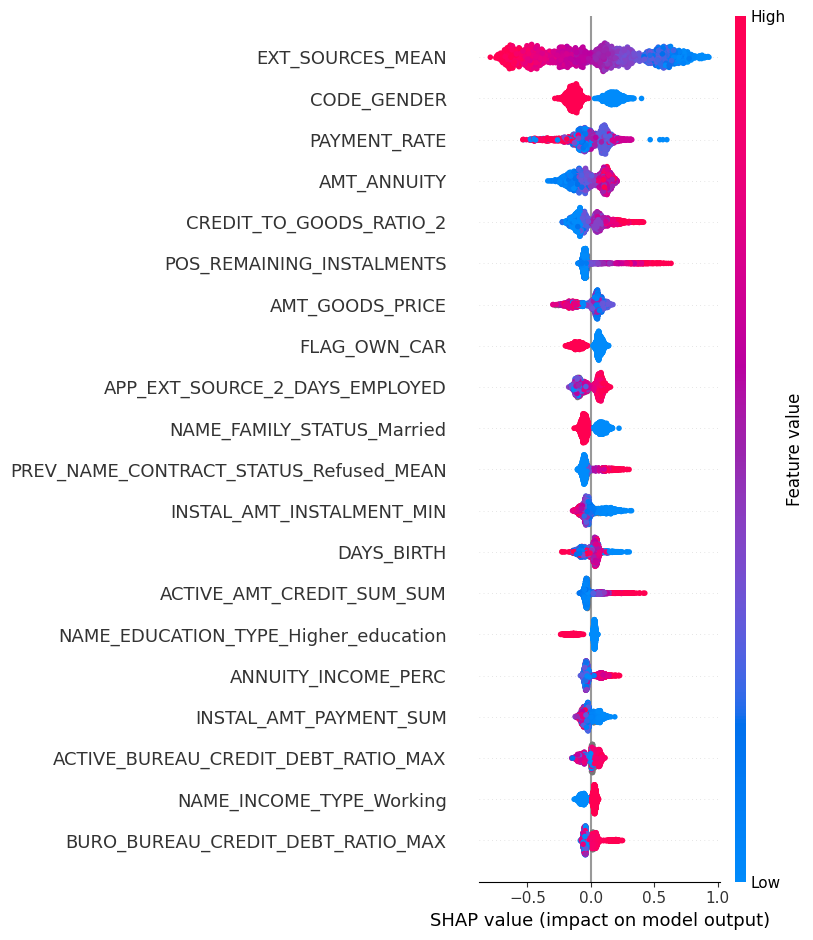

In [ ]:
shap.summary_plot(shap_values_train)

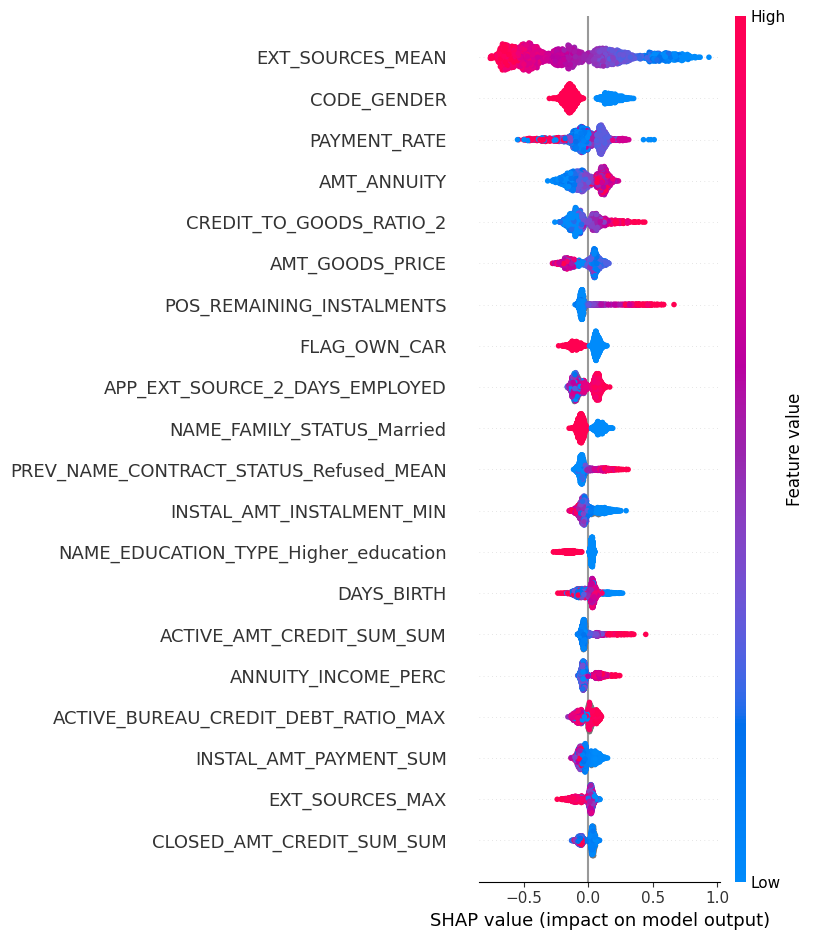

In [ ]:
shap.summary_plot(shap_values_test)

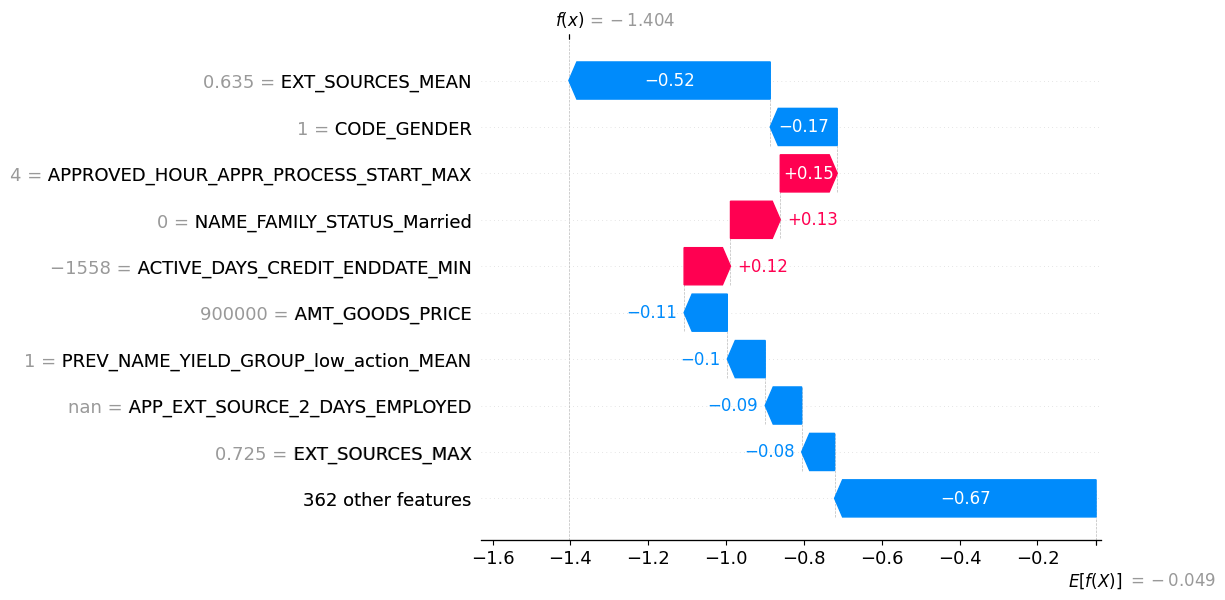

In [ ]:
shap.plots.waterfall(shap_values_train[42])

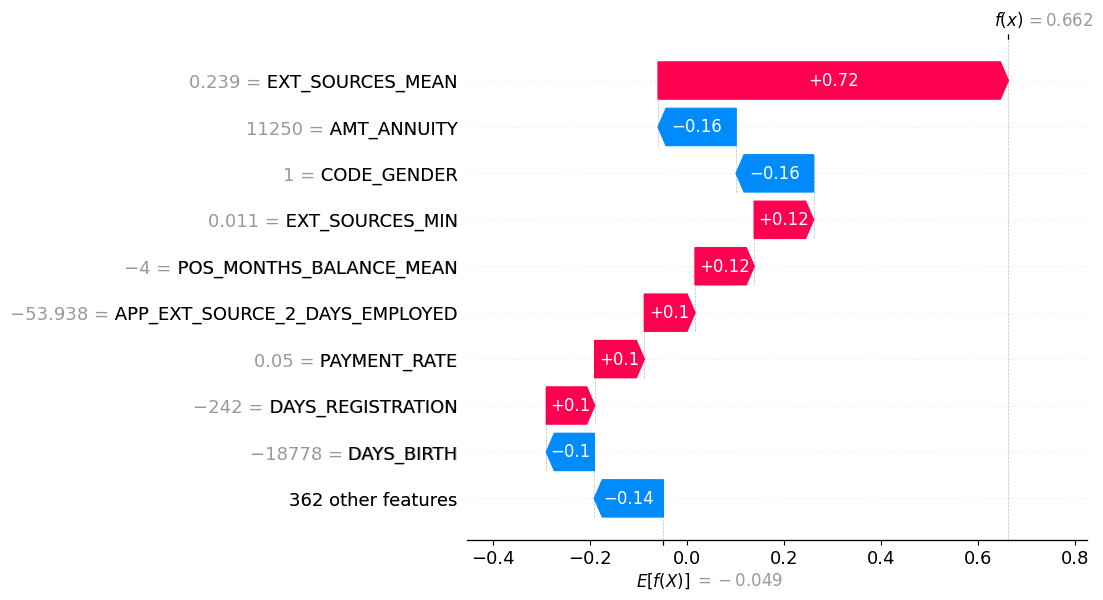

In [ ]:
shap.plots.waterfall(shap_values_train[14])

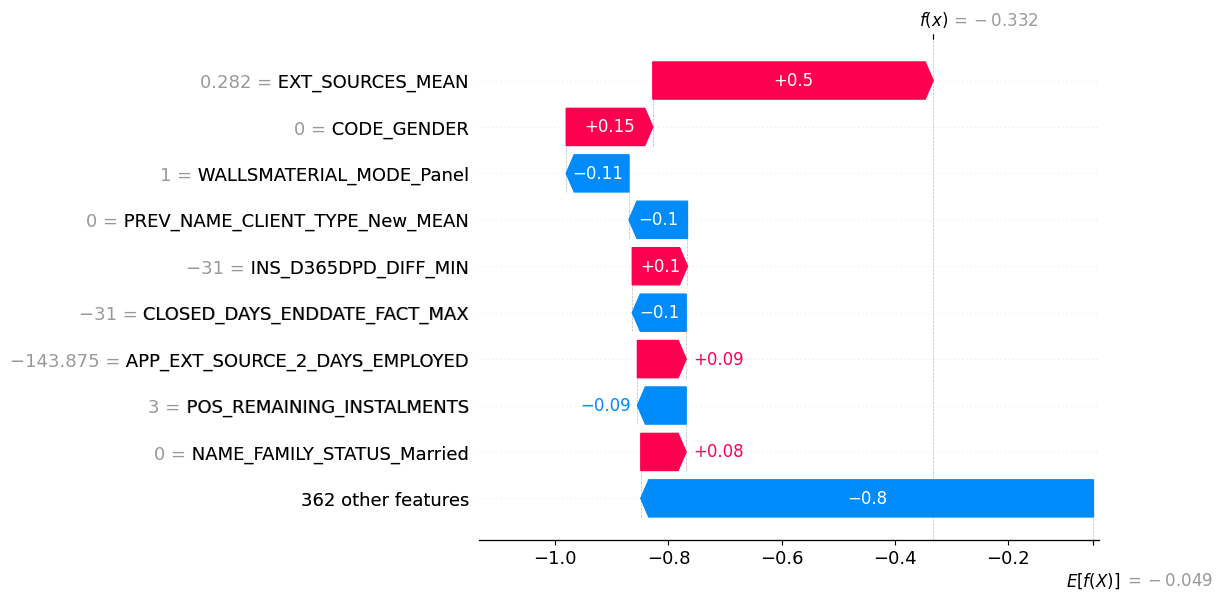

In [ ]:
shap.plots.waterfall(shap_values_train[214])

#Python Versionning

In [ ]:
pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
alembic                       1.10.3
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cac